In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../Wimbledon_featured_matches.csv'
df = pd.read_csv(path)
# df.info()

In [3]:
target_match_id = '2023-wimbledon-1701'
filtered_data = df[df['match_id'] == target_match_id].copy()

In [14]:
"""
计算综合势头得分函数
"""
def calculate_comprehensive_momentum(data, player_number, window_size=3):
    momentum_scores = [0] * len(data)
    consecutive_point_wins = 0  # 追踪连续得分
    consecutive_game_wins = 0  # 追踪连续获胜的局数
    previous_game_winner = None  # 追踪上一局的获胜者

    for i in range(1, len(data)):
        recent_data = data[max(0, i - window_size):i]
        momentum_score = 0

        for _, feature in recent_data.iterrows():
            # 基本的势头得分计算
            P_t = 1 if feature['point_victor'] == player_number else -1
            S_t = 1.2 if feature['server'] == player_number else 1.0
            base_momentum = P_t * S_t
            momentum_score += base_momentum

            # 连续得分补正（线性）
            if P_t == 1:
                consecutive_point_wins += 1
            else:
                consecutive_point_wins = 0  # 在失分时重置
            momentum_score += 0.03 * consecutive_point_wins  # 每连续获胜增加额外得分

            # 连续小局获胜补正（线性）
            if feature['game_victor']:
                current_game_winner = feature['game_victor']
                if current_game_winner == player_number:
                    if current_game_winner == previous_game_winner:
                        consecutive_game_wins += 1
                    else:
                        consecutive_game_wins = 0  # 重置连续获胜局数
                previous_game_winner = current_game_winner
                momentum_score += 0.2 * consecutive_game_wins  # 连续获胜局数的影响

            # 大比分差距补正（指数）
            if feature['set_victor']:
                player1_set = feature['p1_sets'] + 1 if feature['set_victor'] == player_number else feature['p1_sets']
                player2_set = feature['p2_sets'] + 1 if feature['set_victor'] == player_number else feature['p2_sets']
                diff = (player2_set - player1_set) * (-1 ** player_number)  # player1为-1， player2为+1
                momentum_score += 0.1 * (2 ** diff)

            # 小比分差距补正（线性）
            if feature['game_victor']:
                score_diff = abs(feature['p1_games'] - feature['p2_games'])
                momentum_score += 0.02 * score_diff * P_t

            # 破发点的影响
            # if (player_number == 1 and feature['p1_break_pt'] > 0) or (player_number == 2 and feature['p2_break_pt'] > 0):
            #     momentum_score += 0.5 * P_t

            # 拍数和跑动距离的影响
            rally_factor = feature['rally_count'] / 30  # 归一化回合数
            distance_factor = (feature['p1_distance_run'] + feature['p2_distance_run']) / 122  # 归一化跑动距离
            momentum_score += 2.0 * rally_factor * distance_factor * P_t

        momentum_scores[i] = momentum_score

    return momentum_scores

In [15]:
"""
为两位球员计算综合势头得分
"""
filtered_data['comprehensive_momentum_1'] = calculate_comprehensive_momentum(filtered_data, player_number=1)
filtered_data['comprehensive_momentum_2'] = calculate_comprehensive_momentum(filtered_data, player_number=2)

Player 1 had a Negative shift at point number 66, during set 2, game 3. GET -4.1602508196721315
Player 1 had a Positive shift at point number 87, during set 2, game 6. GET 4.151430601092897
Player 1 had a Negative shift at point number 90, during set 2, game 6. GET -4.002491803278689
Player 1 had a Positive shift at point number 151, during set 3, game 2. GET 4.326827868852459
Player 1 had a Negative shift at point number 218, during set 4, game 2. GET -5.337419672131148
Player 2 had a Positive shift at point number 22, during set 1, game 4. GET 4.1808071038251375
Player 2 had a Negative shift at point number 33, during set 1, game 5. GET -4.609883060109291


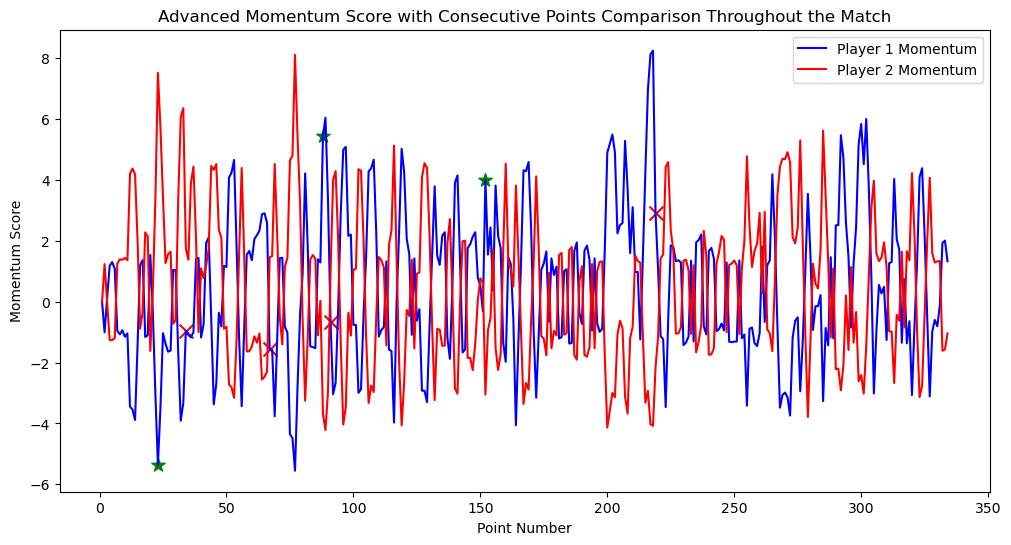

In [16]:
# Define the threshold for a significant momentum shift
threshold = 4

# Initialize lists to store the points of positive and negative shifts for both players
shifts_player_1 = []
shifts_player_2 = []

# Calculate the momentum change for each point and find shifts
for i in range(1, len(filtered_data)):
    change_1 = filtered_data['comprehensive_momentum_1'].iloc[i] - filtered_data['comprehensive_momentum_1'].iloc[i - 1]
    change_2 = filtered_data['comprehensive_momentum_2'].iloc[i] - filtered_data['comprehensive_momentum_2'].iloc[i - 1] 
        
    if abs(change_1) >= threshold:
        shift_type = 'Positive' if change_1 > 0 else 'Negative'
        shifts_player_1.append((i, shift_type, change_1))
    if abs(change_2) >= threshold:
        shift_type = 'Positive' if change_2 > 0 else 'Negative'
        shifts_player_2.append((i, shift_type, change_2))

# Annotation
for point, shift_type, change in shifts_player_1:
    set_no = filtered_data['set_no'].iloc[point]
    game_no = filtered_data['game_no'].iloc[point]
    print(f"Player 1 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}. GET {change}")

for point, shift_type, change in shifts_player_2:
    set_no = filtered_data['set_no'].iloc[point]
    game_no = filtered_data['game_no'].iloc[point]
    print(f"Player 2 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}. GET {change}")
    
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_1'], label='Player 1 Momentum', color='blue')
plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_2'], label='Player 2 Momentum', color='red')

for point, shift_type, _ in shifts_player_1:
    marker = '*' if shift_type == 'Positive' else 'x'
    color = 'green' if shift_type == 'Positive' else 'red'
    plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_1'].iloc[point], 
                color=color, marker=marker, s=100)

for point, shift_type, _ in shifts_player_2:
    marker = '*' if shift_type == 'Positive' else 'x'
    color = 'green' if shift_type == 'Positive' else 'red'
    plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_1'].iloc[point], 
                color=color, marker=marker, s=100)
    
# Add labels and title to the plot
plt.xlabel('Point Number')
plt.ylabel('Momentum Score')
plt.title('Advanced Momentum Score with Consecutive Points Comparison Throughout the Match')
plt.legend()
plt.show()

**v3.0 let threshold = 8, window = 3**

1. 66
    1 -8.76, 2 +8.36    1发球，2胜  40-30 -> 40-40
2. 74
    1 -12.24, 2 +12.09  2发球，2胜  40-30 -> 40-40  跑动距离尤其长（双方平均不到20，120-93），拍数多（29，平均4.46）
3. ...

    峰谷值体现在多拍回合，说明要降低拍数和跑动距离的影响。


**v3.1 let threshold = 4, window = 3， 调整拍数和跑动距离部分的系数**
1. 218
    1 -5.33             2发球，2胜 30-0 -> 30-15
2. ...

    个人觉得大致可以自圆其说，还要增加破发/保发的特征

**v3.2 ...**
1. ...  